# Modélisation Maganza

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
### Définition des paramètres

W = 11e-3            #Largeur de la anche de clarinette
H = 0.48e-3          #Longueur de la anche de clarinette
gamma_air = 1.4     #Indice adiabatique
rho = 1.292         #Masse vol air
c = 343             #Vitesse son
rc = 3e-2           #rayon de la clarinette
Lc = 60e-2          #longueur clarinette
Sc = np.pi*rc**2    #section clarinette
pM = 0.1            #Pression de plaquage statique
#Y_m = 1 /1233.36096998528 #Admittance premier mode
f = c/(4*Lc)        #Fréquence premier mode
print(f)

omega = (2*np.pi*f)           
F1 = 2 * c / Lc                         

T = 2*Lc/c 
fe = 1/T  #il faudra suréchantillonner ? temps très court....

Z0 = rho*c
Zc = Z0/Sc
eps = 0.05

def coeffs(gamma,zeta):
    F0 = zeta*(1-gamma)*np.sqrt(gamma)
    A = zeta*(3 * gamma - 1) / 2 /np.sqrt(gamma)
    B = -zeta*(3*gamma+1)/8/gamma**(3/2)
    C = -zeta*(gamma+1)/16/gamma**(5/2)
    return F0,A,B,C

t_max = 1  #s
fe = 44100 #Hz
compute_time = np.arange(int(t_max/T))*T
time_sim = np.arange(int(t_max*fe))/fe

142.91666666666669


La section $S$ ne rentre pas en compte ? 

Ou alors dans les expressions de A,B et C de même que la pression de bouche $p_m$ et la pression de plaquage $p_M$.

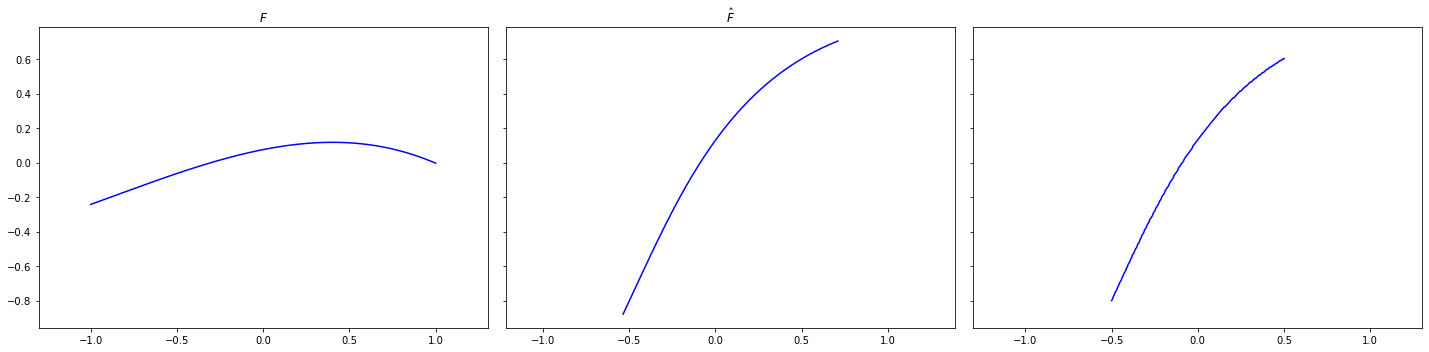

In [11]:
### Définition des fonctions

def F(p,F0,A,B,C):
    "Relation de couplage : u = F(p)"
    return F0+A*p+B*p**2+C*p**3

def rotation_Fhat(x,F0,A,B,C):
    theta = np.pi/4
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    y = F(x,F0,A,B,C)
    X = rotation_matrix @ np.array([[x],[y]])
    return X

def Fhat(p,F0,A,B,C,nb_pts=500):
    x = np.linspace(-2,2,nb_pts)
    liste_G = np.zeros_like(x)
    xprime = np.zeros_like(x)
    for i in range(len(x)):
        #y[i] = F(x[i],F0,A,B,C)
        X = rotation_Fhat(x[i],F0,A,B,C)
        liste_G[i] = X[1]
        xprime[i] = X[0]
        
    ind = 0
    while xprime[ind] < p:
        ind+=1
    
    return liste_G[ind]

def Fcal(x,F0,A,B,C,eps,Z0):
    X = Fhat(x,F0,A,B,C)
    return X*(Z0-eps)/(Z0+eps)

zeta = 0.3 #Zc*W*H*np.sqrt(2/rho/pM)  #W*H/Sc*np.sqrt(2*gamma_air*rho/pM) 

gamma = 0.7  #contrôle : rapport pm/pM

F0,A,B,C = coeffs(gamma,zeta)

x = np.linspace(-1,1,500)
y = F(x,F0,A,B,C)

Fchapeau = np.zeros_like(x)
Fcaligraphie = np.zeros_like(x)
xprime = np.zeros_like(x)
for i in range(len(x)):
    X = rotation_Fhat(x[i],F0,A,B,C)
    Fchapeau[i] = X[1]
    xprime[i] = X[0]

x2 = np.linspace(-0.5,0.5,200)
y2 = np.zeros_like(x2)
for j in range(len(x2)):
    y2[j]=Fhat(x2[j],F0,A,B,C)


fig, axs = plt.subplots(1,3,figsize=(20,5),sharey=True) 

axs[0].plot(x,y,'b')
axs[0].set_title(r"$F$")
axs[0].axis('equal')
axs[1].plot(xprime,Fchapeau,'b')
axs[1].set_title(r"$\hat{F}$")
axs[1].axis('equal')
axs[2].plot(x2,y2,'b')
#axs[2].set_title(r"$F_{cal}$")
axs[2].axis('equal')

fig.tight_layout()

0.06567961217741258


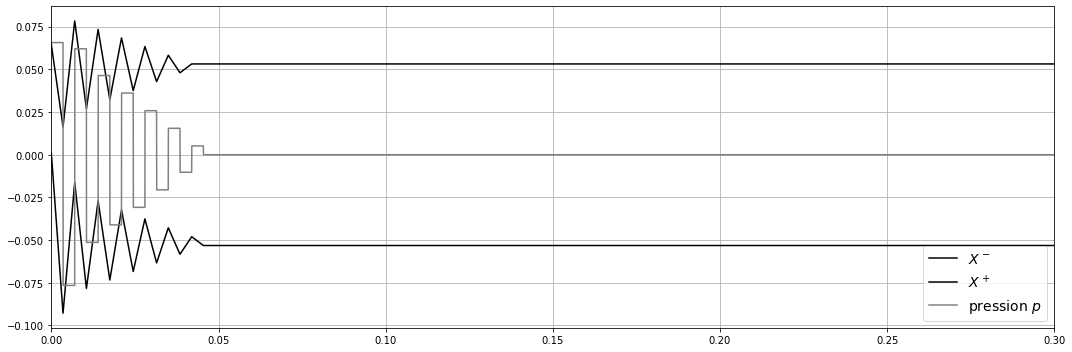

In [5]:
### Initialisation
Ncompute = len(compute_time)
Nsim = len(time_sim)

Xmoins_compute = np.zeros(Ncompute)
Xplus_compute = np.zeros(Ncompute)

zeta = 0.2
gamma = 0.2
F0,A,B,C = coeffs(gamma,zeta)

# Initialisation 

p0 = F0/(1-A)
print(p0)
u0 = F(p0,F0,A,B,C)

Xmoins_compute[0] = (p0 - u0)/2 
Xplus_compute[0] = (p0+u0)/2
#X = Fhat(Xmoins_compute[0],F0,A,B,C)
#Xplus_compute[0] = X[1]

# Calculs

for i in range(1,Ncompute):
    Xmoins_compute[i] = -Fhat(Xmoins_compute[i-1],F0,A,B,C)
    X = Fhat(Xmoins_compute[i],F0,A,B,C)
    Xplus_compute[i] = X
    
Xmoins = np.zeros(Nsim)
Xplus = np.zeros(Nsim)

i = 0
ind = 0
while i < Nsim and ind < Ncompute :
    Xmoins[i] = Xmoins_compute[ind]    
    Xplus[i] = Xplus_compute[ind]
    i+=1 
    time = i/fe
    ind = int(time//T) 
    
p = (Xmoins+Xplus)
f = (Xmoins-Xplus)

plt.figure(figsize=(15,5))
plt.plot(compute_time,Xmoins_compute,color='k',label=r'$X^-$')
plt.plot(compute_time,Xplus_compute,color='k',label=r'$X^+$')
plt.plot(time_sim,p,color='grey',label=r"pression $p$")
plt.legend(fontsize=14)
plt.grid()
plt.xlim(0,0.3)

plt.tight_layout()

Pas le même tps que dans le Chaigne & Kergomard.

$\zeta$ a des valeurs bizarres... + pb sur l'initialisation probablement 

Plusieurs trucs qui vont pas :

- je ne sais pas comment choisir l'initialisation pour $X^-(0)$
- échantillonage à $T = 2L/c$ soit $f_e = 424$ Hz -> on obtient un signal triangle, plus échantillonnage à fréquence trop basse 
- voir si on peut prendre un pas de temps plus faible sans changer la géométrie de l'instrument.

On augmente la fréquence d'échantillonnage, en maintenant à une valeur constante entre $nT$ et $(n+1)T$.

## Version Chaigne & Kergomard

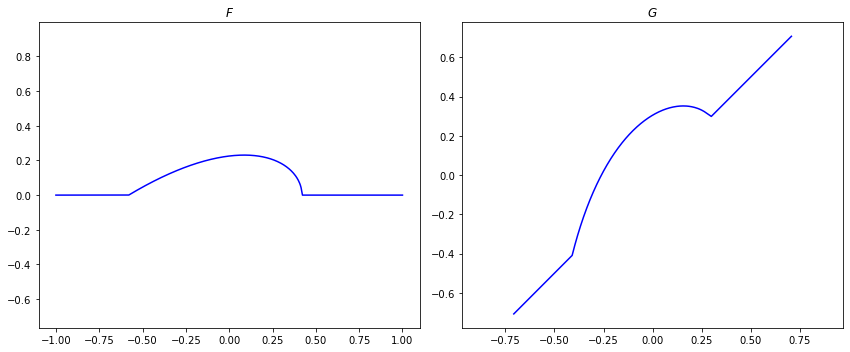

In [6]:
def F(p,gamma, zeta):
    if gamma - p >= 1 or gamma - p < 0 :
        return 0
    else :
        return zeta*(1-gamma+p)*np.sqrt(gamma-p)
    
def rotation_G(x,gamma,zeta):
    theta = np.pi/4
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    y = F(x,gamma,zeta)
    X = rotation_matrix @ np.array([[x],[y]])
    return X

zeta = 0.6 #Zc*W*H*np.sqrt(2/rho/pM)  #W*H/Sc*np.sqrt(2*gamma_air*rho/pM) 
gamma = 0.42  #contrôle : rapport pm/pM

x = np.linspace(-1,1,500)
y = np.zeros_like(x)

Fchapeau = np.zeros_like(x)
Fcaligraphie = np.zeros_like(x)
xprime = np.zeros_like(x)
for i in range(len(x)):
    y[i] = F(x[i],gamma,zeta)
    X = rotation_G(x[i],gamma,zeta)
    Fchapeau[i] = X[1]
    xprime[i] = X[0]

fig, axs = plt.subplots(1,2,figsize=(12,5)) 

axs[0].plot(x,y,'b')
axs[0].set_title(r"$F$")
axs[0].axis('equal')
axs[1].plot(xprime,Fchapeau,'b')
axs[1].set_title(r"$G$")
axs[1].axis('equal')

fig.tight_layout()

In [7]:
def G(p,gamma,zeta,nb_pts=500):
    x = np.linspace(-1,1,nb_pts)
    liste_G = np.zeros_like(x)
    xprime = np.zeros_like(x)
    for i in range(len(x)):
        y[i] = F(x[i],gamma,zeta)
        X = rotation_G(x[i],gamma,zeta)
        liste_G[i] = X[1]
        xprime[i] = X[0]

    ind = 0
    while xprime[ind] < p:
        ind+=1
    
    return liste_G[ind]

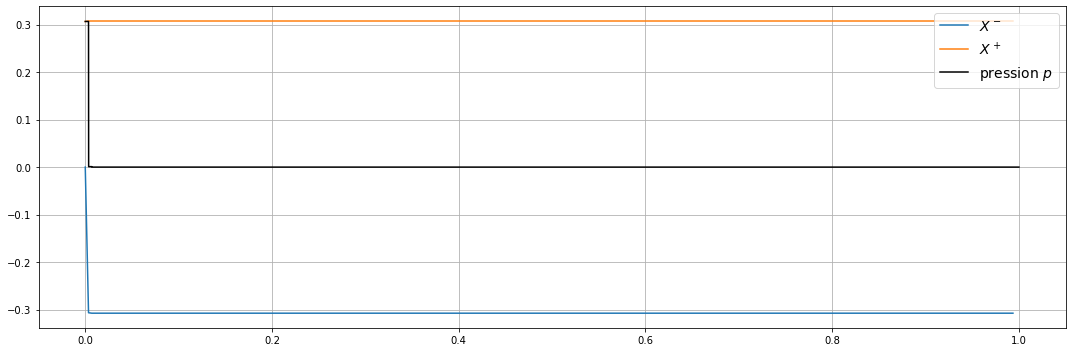

In [8]:
### Initialisation
Ncompute = len(compute_time)
Nsim = len(time_sim)

Xmoins_compute = np.zeros(Ncompute)
Xplus_compute = np.zeros(Ncompute)

zeta = 0.6
gamma = 0.42

# Initialisation 

F0 = zeta*(1-gamma)*np.sqrt(gamma)


Xmoins_compute[0] = 0
Xplus_compute[0] = G(-Xplus_compute[0],gamma,zeta)

# Calculs

for i in range(1,Ncompute):
    Xplus_compute[i] = G(Xplus_compute[i-1],gamma,zeta)
    Xmoins_compute[i] = -Xplus_compute[i-1]
    
Xmoins = np.zeros(Nsim)
Xplus = np.zeros(Nsim)

i = 0
ind = 0
while i < Nsim and ind < Ncompute :
    Xmoins[i] = Xmoins_compute[ind]    
    Xplus[i] = Xplus_compute[ind]
    i+=1 
    time = i/fe
    ind = int(time//T) 
    
p = (Xmoins+Xplus)
f = (Xmoins-Xplus)

plt.figure(figsize=(15,5))
plt.plot(compute_time,Xmoins_compute,label=r'$X^-$')
plt.plot(compute_time,Xplus_compute,label=r'$X^+$')
plt.plot(time_sim,p,color='k',label=r"pression $p$")
plt.legend(fontsize=14)
plt.grid()
#plt.ylim(-1,1)

plt.tight_layout()